In [6]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy

import scvi
from scvi.dataset import CortexDataset, RetinaDataset, CsvDataset
from scvi.dataset.dataset import compute_library_size
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed

#STUFF THAT I MESSED AROUND WITH
from BioDataset import BioDataset
from utils import register_anndata, get_from_registry, compute_library_size_batch
from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
save_path = "data/"
gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()
adata = gene_dataset.to_anndata()

[2020-06-11 12:39:41,615] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/expression.bin already downloaded
[2020-06-11 12:39:41,616] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-06-11 12:39:50,087] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2020-06-11 12:39:51,087] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-11 12:39:51,088] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-11 12:39:53,178] INFO - scvi.dataset.dataset | Downsampling from 19972 to 1000 genes
[2020-06-11 12:39:53,307] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-11 12:39:53,322] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-11 12:39:53,392] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-11 12:39:53,397] INFO - scvi.dataset.dataset | Downsampled from 3005 to 3005 cells
[2020-06-11 12:39:53,409] INFO - scvi.dataset.dataset | Making gen

In [10]:
#compute library size per batch
compute_library_size_batch(adata, 'batch_indices')

data_registry = {
                 X_KEY: (None, 'X'),
                 BATCH_KEY:('obs', 'batch_indices'),
                 LOCAL_L_MEAN_KEY: ('obs', '_scvi_local_l_mean'),
                 LOCAL_L_VAR_KEY: ('obs', '_scvi_local_l_var'),
                 LABELS_KEY: ('obs', 'precise_labels')
                }

register_anndata(adata, data_registry)
bd = BioDataset(adata)


In [11]:
n_epochs = 10
lr = 1e-3
use_cuda = True

vae = VAE(d.nb_genes)
trainer = UnsupervisedTrainer(
    vae,
    bd,
    train_size=0.90,
    n_epochs_kl_warmup = 2,
    use_cuda=use_cuda,
    frequency=5,
)

trainer.train(n_epochs = n_epochs)

> /Users/galen/scVI/scvi/inference/trainer.py(165)train()
-> begin = time.time()


(Pdb)  c


> /Users/galen/scVI/scvi/models/log_likelihood.py(24)compute_elbo()
-> for i_batch, tensors in enumerate(posterior):


(Pdb)  c


> /Users/galen/scVI/scvi/models/log_likelihood.py(24)compute_elbo()
-> for i_batch, tensors in enumerate(posterior):


(Pdb)  c


[2020-06-11 12:41:09,013] INFO - scvi.inference.inference | KL warmup for 2 epochs


> /Users/galen/scVI/scvi/inference/trainer.py(193)train()
-> if tensors_list[0][0].shape[0] < 3:


(Pdb)  c


KeyError: 0

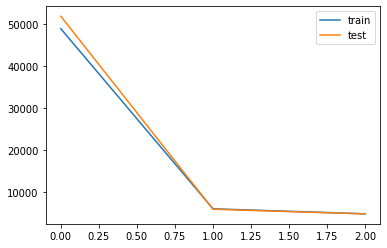

[48998.48844304734, 6093.1965606508875, 4903.550414316753]
[51965.490863787374, 5992.488060631229, 4874.147944352159]


In [37]:
%matplotlib inline
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
# x = np.linspace(0, 2, (len(elbo_train_set)))
x=[i for i in range(len(elbo_train_set))]
plt.plot(x, elbo_train_set, label="train")
plt.plot(x, elbo_test_set, label="test")
# plt.ylim(1500, 3000)
plt.legend()
plt.show()
print(elbo_train_set)
print(elbo_test_set)


In [38]:
full = trainer.create_posterior(trainer.model, d, indices=np.arange(len(gene_dataset)))
 

In [39]:
full = full.update({"batch_size":32})
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [39]:
log_counts = np.ma.log(adata.X).filled(0)
local_mean = np.mean(log_counts)
local_var = np.var(log_counts)
print(local_var)



1.3665342


In [40]:
adata.obs['_scvi_local_l_mean']

0       1.099614
1       1.099614
2       1.099614
3       1.099614
4       1.099614
          ...   
3000    1.099614
3001    1.099614
3002    1.099614
3003    1.099614
3004    1.099614
Name: _scvi_local_l_mean, Length: 3005, dtype: float32

In [42]:
d[1]

['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


(array([100.,   0.,   0.,   0.,   0.,   0.,  28.,  68.,   0.,   0.,   0.,
         86.,   0.,  11.,  55.,   4.,   0.,  14., 187.,   0.,   1.,  86.,
          0.,  15.,  95., 224.,   0.,  56.,   0.,  78.,  12.,  29.,  15.,
         45.,   6.,  80.,   0., 371.,  51.,   8.,  51.,  23.,   2.,  23.,
          2.,  78.,  11.,   0.,   0.,   3.,  45.,   0.,   3.,  30.,  57.,
          0.,  18.,   0.,  22.,  19.,  68.,  38.,   6.,   8.,  39.,  32.,
         33.,   2.,  10.,   0.,   2.,   3.,  37.,   0.,  41.,   0.,   1.,
         62.,  29.,  11.,  29.,  48.,  21.,  22.,  29.,  20.,  52.,   4.,
         31.,  30.,   7.,  37.,  32.,  10.,   0.,  28.,  26.,  25.,   0.,
          1.,   1.,   1.,  28.,  38.,  37.,  20.,  57.,   7.,  19.,  23.,
          5.,   0.,  45.,   9.,  33.,  38.,  39.,  16.,  30., 118.,  67.,
          6.,   0.,  45.,  11.,  35.,   0.,   8.,  20.,   3.,  21.,  12.,
          6.,   0.,   0.,  23.,  15.,  31.,  30.,  34.,   4.,  34.,  32.,
         86.,  19.,  11.,   9.,   0., 

In [51]:
np.unique(adata.obs['batch_indices'])

array([0], dtype=uint16)

In [52]:
register_anndata(adata, batch_key='batch_indices')


In [53]:
a = get_anndata_field(adata, 'batch_indices')
print(a)

0       0
1       0
2       0
3       0
4       0
       ..
3000    0
3001    0
3002    0
3003    0
3004    0
Name: batch_indices, Length: 3005, dtype: uint16


In [54]:
a = get_anndata_field(adata, 'X')
print(a)

[[8.220e+02 0.000e+00 0.000e+00 ... 0.000e+00 6.000e+00 1.200e+01]
 [8.690e+02 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 5.000e+00]
 [1.237e+03 1.000e+00 0.000e+00 ... 0.000e+00 8.000e+00 1.200e+01]
 ...
 [3.760e+02 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [3.030e+02 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.420e+02 2.800e+01 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]


In [38]:
adata.X[1][0] = 100

we are in iter
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'l

TypeError: can't convert np.ndarray of type numpy.uint16. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
['X', 'batch_indices', 'local_l_mean', '

TypeError: can't convert np.ndarray of type numpy.uint16. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.